In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from torch_wavefunction import *

Using device: cuda


/home/pau/software/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Energy = 11.743207
Epoch 100: Energy = 1.239877
Epoch 200: Energy = 0.504831
Epoch 300: Energy = 0.502521
Epoch 400: Energy = 0.501436
Epoch 500: Energy = 0.500947
Epoch 600: Energy = 0.500666
Epoch 700: Energy = 0.500498
Epoch 800: Energy = 0.500385
Epoch 900: Energy = 0.500302
Epoch 0: Energy = 47.314430
Epoch 100: Energy = 3.322455
Epoch 200: Energy = 1.614910
Epoch 300: Energy = 1.552762
Epoch 400: Energy = 1.530700
Epoch 500: Energy = 1.520649
Epoch 600: Energy = 1.516397
Epoch 700: Energy = 1.511314
Epoch 800: Energy = 1.509517
Epoch 900: Energy = 1.507498
Epoch 1000: Energy = 1.546943
Epoch 1100: Energy = 1.505903
Epoch 1200: Energy = 1.504237
Epoch 1300: Energy = 1.503809
Epoch 1400: Energy = 1.509397
Epoch 1500: Energy = 1.504490
Epoch 1600: Energy = 1.502639
Epoch 1700: Energy = 1.512998
Epoch 1800: Energy = 1.505391
Epoch 1900: Energy = 1.502177
Epoch 2000: Energy = 1.502087
Epoch 2100: Energy = 1.501621
Epoch 2200: Energy = 1.501469
Epoch 2300: Energy = 1.501493
Ep

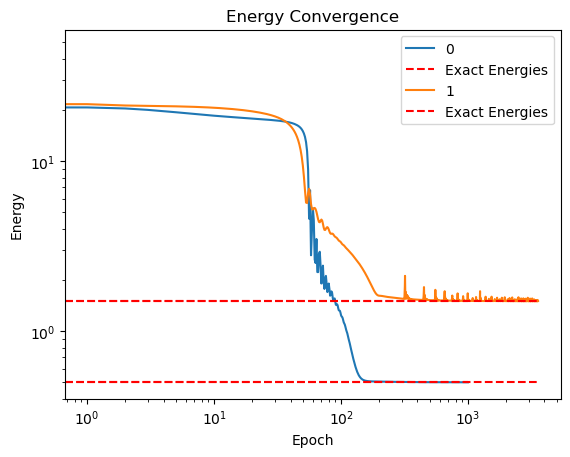

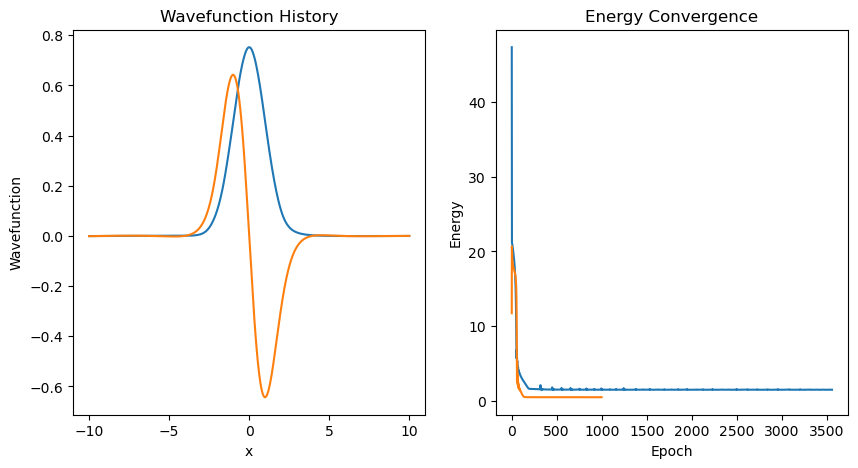

In [2]:
x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device).view(-1, 1)
x_train.requires_grad = True
model = WaveFunctionMLP().to(device)
early_stopping = EarlyStoppingCallback(patience=250, min_delta=1e-5)
psi_normalized, energy_fin, energy_hist_0, wf_hist_0, psi_normalized_torch = train_wavefunction(model, x_train, epochs=1000, save_wavefunction_history=True, callback=early_stopping)
model2 = WaveFunctionMLP([1,80,80,80,1]).to(device)
early_stopping = EarlyStoppingCallback(patience=300, min_delta=1e-4)
psi_normalized_2, energy_fin_2, energy_hist_1, wave_function_history,_ = train_wavefunction(model2, x_train, lr=0.001, previous_wavefunctions=[psi_normalized_torch], epochs=10000, callback=early_stopping, save_wavefunction_history=True,)
def analytic_solution(x):
    return (1/np.pi)**0.25 * np.exp(-0.5*x**2)
def np_abs2(x):
    """Compute the absolute square of a complex number."""
    return np.real(np.real(x)**2 + np.imag(x)**2)

def torch_analytic_solution(x):
    return (1/np.pi)**0.25 * torch.exp(-0.5*x**2)

with torch.no_grad():
    
    def exact_solution(x,n):
        hermite_poly = hermite(n)
        coeff = np.sqrt(1 / (2**n * factorial(n))) * (1 / np.pi)**0.25
        return coeff * np.exp(-0.5*x**2) * hermite_poly(x)
    
    def exact_energy(n):
        return n + 0.5
    
    import matplotlib.animation as animation
    
    def generate_anim(wave_function_history, x_train, n=0, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots()
        print(f"Wavefunction history size: {len(wave_function_history)}")
        psi_exact = exact_solution(x_train.cpu().numpy(), n)
        
        ax.plot(x_train.cpu().numpy(), np_abs2(psi_exact), label="Exact Solution", linestyle='--', color="#666666", linewidth=1)
        line, = ax.plot(x_train.cpu().numpy(), np_abs2(wave_function_history[0]), label="NQS", color="orange")
        ax.set_ylim(-0.1, 0.65)
        ax.set_ylabel("|ψ|²")
        ax.set_xlabel("x")
        ax.legend()
        def update(frame):
            line.set_ydata(np_abs2(wave_function_history[frame]))
            ax.set_title(f"Epoch {frame*10}")
            return line,
        plt.close(fig)  # Close the figure to prevent it from displaying immediately

        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
        
    generate_anim(wf_hist_0, x_train, n=0, filename="GS.gif")
    generate_anim(wave_function_history, x_train,n=1, filename="1st.gif")

    def generate_energy_plot(energy_hists):
        for i, energy_hist in enumerate(energy_hists):
            plt.plot(energy_hist, label=f"{i}")
            plt.hlines([exact_energy(i) for i in range(len(energy_hists))], color='red', linestyle='--', label="Exact Energies", xmin=0, xmax=len(energy_hist))
        plt.xlabel("Epoch")
        plt.ylabel("Energy")
        plt.title("Energy Convergence")
        plt.loglog()
        plt.legend()
        plt.show()
    generate_energy_plot([energy_hist_0, energy_hist_1])
    
    
    
    final_wavefunction = model(x_train)
    normalization = torch.sqrt(torch.trapz(torch_abs2(final_wavefunction), x_train,dim=0))
    
    final_wavefunction /= normalization
    final_wavefunction_cpu = final_wavefunction.cpu().numpy()
    
    probability_density = torch_abs2(final_wavefunction).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(x_train.cpu().numpy(), psi_normalized, label="Probability Density")
    plt.plot(x_train.cpu().numpy(), psi_normalized_2, label="Probability Density 2")
    plt.xlabel("x")
    plt.ylabel("Wavefunction")
    plt.title("Wavefunction History")
    plt.subplot(1,2,2)
    plt.plot(energy_hist_1, label="Energy History")
    plt.xlabel("Epoch")
    plt.ylabel("Energy")
    plt.plot(energy_hist_0, label="Energy History 0")
    plt.title("Energy Convergence")
    
    plt.show()

/home/pau/PhD/1D-Variational-RBM/python/torch_wavefunction.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.b = nn.Parameter(torch.tensor(params["b"], dtype=self.type_var, device=device))
/home/pau/PhD/1D-Variational-RBM/python/torch_wavefunction.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.c = nn.Parameter(torch.tensor(params["c"], dtype=self.type_var, device=device))
/home/pau/PhD/1D-Variational-RBM/python/torch_wavefunction.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.w = nn.Parameter(torch.tensor(par

Epoch 0: Energy = 5.692854
Epoch 100: Energy = 0.524018
Epoch 200: Energy = 0.514020
Epoch 300: Energy = 0.509371
Epoch 400: Energy = 0.506573
Epoch 500: Energy = 0.504820
Epoch 600: Energy = 0.503665
Epoch 700: Energy = 0.502871
Epoch 800: Energy = 0.502302
Epoch 900: Energy = 0.501883
Epoch 0: Energy = 23.644030
Epoch 100: Energy = 22.810563
Epoch 200: Energy = 22.141265
Epoch 300: Energy = 21.603571
Epoch 400: Energy = 21.167961
Epoch 500: Energy = 20.810798
Epoch 600: Energy = 20.513785
Epoch 700: Energy = 20.262987
Epoch 800: Energy = 20.047847
Epoch 900: Energy = 19.860427
Epoch 1000: Energy = 19.694742
Epoch 1100: Energy = 19.546351
Epoch 1200: Energy = 19.411933
Epoch 1300: Energy = 19.288992
Epoch 1400: Energy = 19.175635
Epoch 1500: Energy = 19.070399
Epoch 1600: Energy = 18.972140
Epoch 1700: Energy = 18.879915
Epoch 1800: Energy = 18.792957
Epoch 1900: Energy = 18.710616
Epoch 2000: Energy = 18.632350
Epoch 2100: Energy = 18.557681
Epoch 2200: Energy = 18.486209
Epoch 2300:

/home/pau/software/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pau/software/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


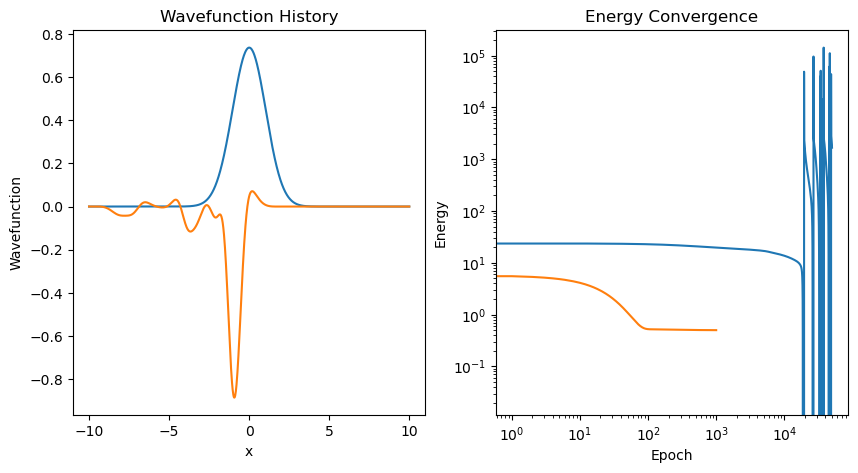

In [6]:
Nh = 10
params = {
    "b": torch.randn(1, dtype=torch.float32, device=device),
    "c": torch.randn(Nh, dtype=torch.float32, device=device),
    "w": torch.randn(Nh, dtype=torch.float32, device=device),
    "Nh": Nh,
    "is_complex": False
}
model = WaveFunctionNN(params).to(device)

x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device)
x_train.requires_grad = True

psi_normalized, energy_fin, energy_hist_0, _, psi_normalized_torch = train_wavefunction(model, x_train)

complex_type = torch.complex128
Nh = 40
params = {
    "b": torch.randn(1, dtype=complex_type, device=device),
    "c": torch.randn(Nh, dtype=complex_type, device=device),
    "w": torch.randn(Nh, dtype=complex_type, device=device),
    "Nh": Nh,
    "is_complex": True
}
model = WaveFunctionNN(params).to(device)

x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device)
x_train.requires_grad = True
psi_normalized_2, energy_fin_2, energy_hist_1, wave_function_history,_ = train_wavefunction(model, x_train, previous_wavefunctions=[psi_normalized_torch], epochs=50000, lr=0.00001, save_wavefunction_history=True)

def analytic_solution(x):
    return (1/np.pi)**0.25 * np.exp(-0.5*x**2)
def np_abs2(x):
    """Compute the absolute square of a complex number."""
    return np.real(np.real(x)**2 + np.imag(x)**2)

def torch_analytic_solution(x):
    return (1/np.pi)**0.25 * torch.exp(-0.5*x**2)

with torch.no_grad():

    def generate_anim(wave_function_history, x_train, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots()
        print(f"Wavefunction history size: {len(wave_function_history)}")
        
        line, = ax.plot(x_train.cpu().numpy(), np_abs2(wave_function_history[0]), label="NQS", color="orange")
        ax.set_ylim(-0.1, 0.65)
        ax.set_ylabel("|ψ|²")
        ax.set_xlabel("x")
        ax.legend()
        def update(frame):
            line.set_ydata(np_abs2(wave_function_history[frame]))
            ax.set_title(f"Epoch {frame*10}")
            return line,
        plt.close(fig)  # Close the figure to prevent it from displaying immediately

        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
    
    def generate_wavefunc_anim(wave_function_history, x_train, filename="wavefunction_animation.gif"):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        
        print(f"Wavefunction history size: {len(wave_function_history)}")
        
        line, = ax[0].plot(x_train.cpu().numpy(), wave_function_history[0].real, label="NQS", color="orange")
        line2, = ax[1].plot(x_train.cpu().numpy(), wave_function_history[0].imag, label="NQS", color="orange")
        ax[0].set_ylim(-0.1, 0.65)
        ax[0].set_ylabel("Real part")
        ax[1].set_ylim(-0.1, 0.65)
        ax[1].set_ylabel("Imaginary part")
        ax[0].set_xlabel("x")
        ax[1].set_xlabel("x")
        ax[0].legend()
        ax[1].legend()
        def update(frame):
            line.set_ydata(wave_function_history[frame].real)
            line2.set_ydata(wave_function_history[frame].imag)
            ax[0].set_title(f"Epoch {frame*10}")
            ax[1].set_title(f"Epoch {frame*10}")
            return line, line2
        plt.close(fig)  # Close the figure to prevent it from displaying immediately
        
        ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
        ani.save(filename, writer='pillow', fps=10)
    
        
    generate_anim(wave_function_history, x_train, filename="probability_RBM.gif")
    generate_wavefunc_anim(wave_function_history, x_train, filename="wavefunction_RBM.gif")
    
    final_wavefunction = model(x_train)
    normalization = torch.sqrt(torch.trapz(torch_abs2(final_wavefunction), x_train))
    
    final_wavefunction /= normalization
    final_wavefunction_cpu = final_wavefunction.cpu().numpy()
    
    # is_fin_wf_normalized = torch.allclose(torch.trapz(torch_abs2(final_wavefunction), x_train), torch.tensor(1.0, device=device), atol=1e-6)
    # print(f"Is final wavefunction normalized? {is_fin_wf_normalized}")
    
    probability_density = torch_abs2(final_wavefunction).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(x_train.cpu().numpy(), psi_normalized, label="Probability Density")
    plt.plot(x_train.cpu().numpy(), psi_normalized_2, label="Probability Density 2")
    plt.xlabel("x")
    plt.ylabel("Wavefunction")
    plt.title("Wavefunction History")
    plt.subplot(1,2,2)
    plt.plot(energy_hist_1, label="Energy History")
    plt.xlabel("Epoch")
    plt.ylabel("Energy")
    plt.plot(energy_hist_0, label="Energy History 0")
    plt.title("Energy Convergence")
    plt.loglog()
    
    plt.show()

In [4]:
from torch_wavefunction import *
Nv = 21
RBM_OHE = WaveFunctionRBM_OHE(Nv, 10)
RBM_OHE.to(device)
x_train = torch.linspace(-10, 10, 100, dtype=torch.float32, device=device)
x_train.requires_grad = True

psi = RBM_OHE(x_train)

print(torch.autograd.grad(psi.sum(), x_train, allow_unused=True)[0])

None
